In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib

In [4]:
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
import palettable

In [6]:
import sys
import pathlib

### import the local package 

In [7]:
sys.path.append('../../')

In [8]:
import seaborn as sns

In [9]:
from ICU_Water_Watch import C3S, geo, plot, utils, verification, domains

In [10]:
from datetime import datetime, timedelta
from calendar import month_abbr

In [11]:
import numpy as np
import pandas as pd 
import xarray as xr

In [12]:
import cartopy.crs as ccrs 

In [13]:
from shapely.geometry import Point, Polygon
import regionmask

### climpred HindcastEnsemble Class

In [14]:
from climpred import HindcastEnsemble

### logging, to see what `climpred` is doing under the hood 

In [15]:
import logging
logger = logging.getLogger()

logger.setLevel(logging.INFO) # minimum and maximum bounds for initializations and verification dates

# logger.setLevel(logging.DEBUG) # every single initialisation and verif date used 

### progress bar for dask compute 

In [16]:
from dask.diagnostics import ProgressBar

In [17]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### path definitions 

In [18]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [19]:
fig_path = CWD.parents[1].joinpath('figures/verification/SST')

In [20]:
fig_path

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/figures/verification/SST')

### domain for the calculation of the ACC 

In [21]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

### parameters (for papermill)

In [37]:
varname = 'sst'
domain_name = 'NZ'
period = 'seasonal'
use_verif = 'oisst'
year_start = 1993 
year_end = 2016
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP','JMA']

### plots the domain 

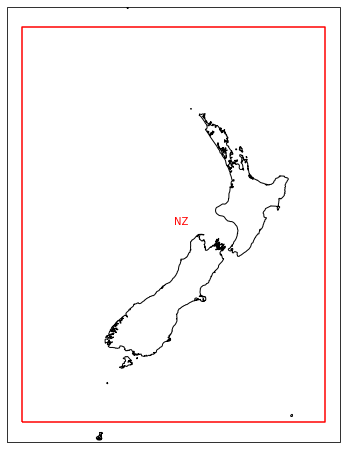

In [23]:
f = domains.plot_domains(domain_name=domain_name)

In [24]:
domain = domains.domains[domain_name]

In [25]:
domain

[161, 181, -50, -30]

### read the observations (ERSST or OISST)

In [26]:
if use_verif == 'oisst': 
    _, dset_obs = verification.get_OISST()
elif use_verif == 'ersst': 
    _, dset_obs = verification.get_ERSST()

In [27]:
dset_obs = utils.interp_to_1x(dset_obs)

In [28]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

In [29]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 20, lon: 20)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float64 -49.88 -48.88 -47.88 -46.88 ... -32.88 -31.88 -30.88
  * lon      (lon) float64 161.1 162.1 163.1 164.1 ... 177.1 178.1 179.1 180.1
Data variables:
    sst      (time, lat, lon) float64 0.06645 0.02466 0.1355 ... 0.3028 0.8062

In [30]:
mask_obs = dset_obs.mean(dim='time')

In [31]:
mask_obs = mask_obs.where(np.isnan(mask_obs), 1)

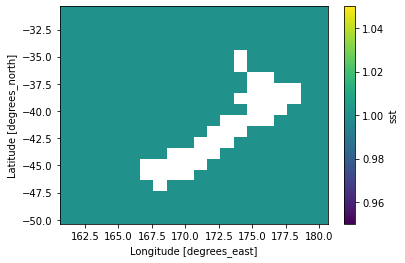

In [32]:
mask_obs['sst'].plot()

In [33]:
mask_obs = mask_obs.rename({'sst':'mask'})['mask']

In [34]:
if period == 'seasonal': 
    dset_obs = dset_obs.rolling({'time':3}, min_periods=3).mean('time')
    dset_obs = dset_obs.isel(time=slice(2, None))

### reads the GCMs 

In [39]:
MME = C3S.get_GCMs(GCM=GCMs, domain=domain, varname=varname, anomalies=True)

---------------------------------------------------
reading ECMWF

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/ECMWF/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/SST/ensemble_seas_forecasts_sst_from_1993_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/SST/ensemble_seas_forecasts_sst_from_2016_12_ECMWF.netcdf
---------------------------------------------------
reading UKMO

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/UKMO/SST
reading 287 files

first: /media/nicolasf/END19101/ICU/data/CDS/UKMO/SST/ensemble_seas_forecasts_sst_from_1993_02_UKMO.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/UKMO/SST/ensemble_seas_forecasts_sst_from_2016_12_UKMO.netcdf
---------------------------------------------------
reading METEO_FRANCE

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/METEO_FRANCE/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/METEO_FRANCE/SST/ensemble_seas_forecasts_sst_

### drop the first month, which is missing in UKMO, as well as 1997 - 8 - 1, which is empty in NCEP 

In [41]:
MME = MME.drop_sel(time='1993-01-01')

In [42]:
MME = MME.drop_sel(time='1997-08-01')

### calculates the seasonal values if needed 

In [43]:
if period == 'seasonal': 
    MME = MME.rolling({'step':3}, min_periods=3).mean('step')
    MME = MME.sel(step=slice(3, None))

In [44]:
MME = MME.transpose("GCM", "time", "step", "lat", "lon")

In [45]:
sst_interp = utils.interpolate_NaN_da(MME['sst'].load())

In [46]:
MME['sst'] = sst_interp

### re-chunk, each chunk will take ~ 7 Mb in memory

In [47]:
MME = MME.chunk({'GCM':-1, 'time':-1, 'step':-1, 'lon':-1, 'lat':-1})

In [48]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 7, lon: 21, lat: 21, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'JMA'
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * step     (step) int64 3 4 5
    month    (GCM, time) float64 dask.array<chunksize=(7, 286), meta=np.ndarray>
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(7, 286, 3, 21, 21), meta=np.ndarray>

### add the ensemble mean to the set of GCMs

In [49]:
MME_mean = MME.mean('GCM')

In [50]:
MME_mean

<xarray.Dataset>
Dimensions:  (time: 286, lon: 21, lat: 21, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * step     (step) int64 3 4 5
Data variables:
    sst      (time, step, lat, lon) float64 dask.array<chunksize=(286, 3, 21, 21), meta=np.ndarray>

In [51]:
MME_mean = MME_mean.expand_dims({'GCM':['MME']})

In [52]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 7, lon: 21, lat: 21, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'JMA'
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * step     (step) int64 3 4 5
    month    (GCM, time) float64 dask.array<chunksize=(7, 286), meta=np.ndarray>
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(7, 286, 3, 21, 21), meta=np.ndarray>

In [53]:
if 'month' in MME.coords: 
    MME = MME.drop('month')

In [54]:
MME = xr.concat([MME, MME_mean], dim='GCM')

In [55]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 8, lon: 21, lat: 21, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * step     (step) int64 3 4 5
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(7, 286, 3, 21, 21), meta=np.ndarray>

### process to make all the variables and dimension names compatible with climpred

In [56]:
MME = verification.process_for_climpred(MME)

### re-chunk the MME 

In [57]:
MME = MME.chunk({'init':-1, 'lead':1, 'lat':-1, 'lon':-1})

In [58]:
MME

<xarray.Dataset>
Dimensions:  (init: 286, GCM: 8, lon: 21, lat: 21, lead: 3)
Coordinates:
  * init     (init) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * lead     (lead) int64 3 4 5
Data variables:
    sst      (GCM, init, lead, lat, lon) float64 dask.array<chunksize=(7, 286, 1, 21, 21), meta=np.ndarray>

### re-chunk the observations 

In [59]:
dset_obs = dset_obs.chunk({'time':-1, 'lat':-1, 'lon':-1})

In [60]:
dset_obs.chunks

Frozen({'time': (286,), 'lat': (20,), 'lon': (20,)})

### create the hindcast ensemble over all the GCMs (including the MME)

In [61]:
hindcast = HindcastEnsemble(MME)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [62]:
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (init: 286, GCM: 8, lon: 21, lat: 21, lead: 3)
Coordinates:
 * init (init) object 1993-02-01 00:00:00 ... 2016-12-01 00:00:00
 * GCM (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' ... 'NCEP' 'JMA' 'MME'
 * lon (lon) float32 161.0 162.0 163.0 164.0 ... 179.0 180.0 181.0
 * lat (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -32.0 -31.0 -30.0
 * lead (lead) int64 3 4 5
 valid_time (lead, init) object 1993-05-01 00:00:00 ... 2017-05-01 00:00:00
Data variables:
 sst (GCM, init, lead, lat, lon) float64 dask.array<chunksize=(7, 286, 1, 21, 21), meta=np.ndarray> Initialized Ensemble Dimensions: init : 286 GCM : 8 lon : 21 lat : 21 lead : 3 Coordinates: (6) init (init) object 1993-02-01 00:00:00 ... 2016-12-... standard_name : forecast_reference_time long_name : Initialization description : The forecast reference time in NWP is the "data time", the time of the analysis from which the forecast was made. It is not the time for which the forecast is valid; the standard name of time should be used for that time. array([cftime.DatetimeProlepticGregorian(1993, 2, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 3, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 4, 1, 0, 0, 0, 0, has_year_zero=True),
 ...,
 cftime.DatetimeProlepticGregorian(2016, 10, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 11, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(2016, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
 dtype=object) GCM (GCM) <U12 'ECMWF' 'UKMO' ... 'JMA' 'MME' array(['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA', 'MME'],
 dtype='<U12') lon (lon) float32 161.0 162.0 163.0 ... 180.0 181.0 array([161., 162., 163., 164., 165., 166., 167., 168., 169., 170., 171., 172.,
 173., 174., 175., 176., 177., 178., 179., 180., 181.], dtype=float32) lat (lat) float32 -50.0 -49.0 -48.0 ... -31.0 -30.0 units : degrees_north long_name : latitude array([-50., -49., -48., -47., -46., -45., -44., -43., -42., -41., -40., -39.,
 -38., -37., -36., -35., -34., -33., -32., -31., -30.], dtype=float32) lead (lead) int64 3 4 5 units : months standard_name : forecast_period long_name : Lead description : Forecast period is the time interval between the forecast reference time and the validity time. A period is an interval of time, or the time-period of an oscillation. array([3, 4, 5]) valid_time (lead, init) object 1993-05-01 00:00:00 ... 2017-05-... long_name : validity time standard_name : time description : time for which the forecast is valid calculate : init + lead amip : time array([[cftime.DatetimeProlepticGregorian(1993, 5, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 6, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 7, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 8, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 9, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 10, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 11, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1993, 12, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 1, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 2, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 3, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 4, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 5, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 6, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 7, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 8, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime.DatetimeProlepticGregorian(1994, 9, 1, 0, 0, 0, 0, has_year_zero=True),
 cftime

### repeat the observations over the `GCM` dimension 

In [63]:
dset_obs_repeat = xr.concat([dset_obs for i in range(len(MME['GCM']))], dim='GCM') 
dset_obs_repeat['GCM'] = MME['GCM']

In [64]:
hindcast = hindcast.add_observations(dset_obs_repeat)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


### calculate the ACC variability (i.e. for **each** initial month and year)

In [65]:
ACC_variability = hindcast.verify(metric='acc', comparison='e2o', dim=['lat','lon'], alignment='maximize')

ValueError: indexes along dimension 'lat_lon' are not equal

### do the same for the RMSE

In [ ]:
RMSE_variability = hindcast.verify(metric='rmse', comparison='e2o', dim=['lat','lon'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    ACC_variability = ACC_variability.compute()
    RMSE_variability = RMSE_variability.compute()

### ACC variability plot for each lead time 

In [ ]:
CWD

In [ ]:
for lead in ACC_variability.lead.data: 
    f, ax = plt.subplots(figsize=(10,6))
    for GCM in GCMs: 
        ACC_variability.sel(GCM=GCM, lead=lead)['precip'].plot(ax=ax, lw=1, color='0.4')
    ACC_variability.sel(GCM="MME", lead=lead)['precip'].plot(ax=ax, color='k', lw=2)
    ACC_variability.sel(GCM="MME", lead=lead)['precip'].rolling({'init':5}, center=True).mean().plot(ax=ax, color='b', lw=2)
    ax.grid(ls=':')
    ax.axhspan(0.3, 1, color='g', alpha=0.1)
    ax.axhspan(0.4, 1, color='g', alpha=0.2)
    ax.axhspan(0.6, 1, color='g', alpha=0.3)
    ax.set_ylim(None, 1)
    ax.axhline(0, color='r')
    ax.set_title(f'MME ACC variability, {period}, lead {lead} month, vs {use_verif.upper()} precipitation')
    ax.set_ylabel('ACC')
    ax.set_xlabel('')
    f.savefig(fig_path.joinpath(f'ACC_variability_MME_{varname}_vs_{use_verif.upper()}_lead_{lead}_{domain_name}_domain.png'), dpi=200, bbox_inches='tight', facecolor='w')

### Now calculates the ACC for all init times, along lat and lon 

In [ ]:
ACC = hindcast.verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
RMSE = hindcast.verify(metric='rmse', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    ACC = ACC.compute()

In [ ]:
with ProgressBar(): 
    RMSE = RMSE.compute()

In [ ]:
ACC

In [ ]:
RMSE

In [ ]:
ACC_df = ACC['precip'].to_dataframe()['precip'].unstack()

In [ ]:
RMSE_df = RMSE['precip'].to_dataframe()['precip'].unstack()

### save the ACC and RMSE dataframes to disk for later plotting 

In [ ]:
ACC_df.to_csv(f"./outputs_paper/ACC_df_{domain_name}_{period}.csv")

In [ ]:
RMSE_df.to_csv(f"./outputs_paper/RMSE_df_{domain_name}_{period}.csv")

In [ ]:
print(str(fig_path))

### plots of the ACC and RMSE

In [ ]:
f, ax = plt.subplots(figsize=(6,7))
ACC_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax)
# ACC_df.loc[:,'Best_5'].plot(marker='s', markersize=10, ax=ax, color='0.4', label='Best 5', lw=4)
ACC_df.loc[:,'MME'].plot(marker='*', markersize=15, ax=ax, color='k', label='MME', lw=4)
ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(ACC.lead.data)
ax.grid(ls=':')
ax.set_title(f"{period} ACC [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_ylim(0.25, 0.70)

plt.legend(loc=(1.01, 0.5), frameon=False); 

# f.savefig(f'../../figures/validation/ACC_{"to".join(map(str, domain))}_verif_{use_verif.upper()}.png', dpi=200, bbox_inches='tight', facecolor='w')
f.savefig(fig_path.joinpath(f'ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_maximize_alignment.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

In [ ]:
f, ax = plt.subplots(figsize=(6,7))
RMSE_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax)
# RMSE_df.loc[:,'Best_5'].plot(marker='s', markersize=10, ax=ax, color='0.4', label='Best 4', lw=4)
RMSE_df.loc[:,'MME'].plot(marker='*', markersize=15, ax=ax, color='k', label='MME', lw=4)
ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"RMSE (mm/month) [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=13);
ax.set_xticks(RMSE.lead.data)
ax.grid(ls=':')
ax.set_title(f"{period} RMSE (mm/month) [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# ax.set_ylim(0.15, 0.45)

plt.legend(loc=(1.01, 0.5), frameon=False); 

f.savefig(fig_path.joinpath(f'RMSE_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_maximize_alignment.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

### per month 

In [ ]:
ACC_per_month = []

for label, group in MME.groupby('init.month'):
    
    print(f"calculating metric for month {label}\n")

    hindcast_month = HindcastEnsemble(group)

    hindcast_month = hindcast_month.add_observations(dset_obs_repeat)

    skill_monthly = hindcast_month.verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')
    
    with ProgressBar(): 
        
        skill_monthly = skill_monthly.compute()

    ACC_per_month.append(skill_monthly.expand_dims({'month':[label]}))

In [ ]:
ACC_per_month = xr.concat(ACC_per_month, dim='month') 

In [ ]:
ACC_per_month.lead.data[::-1]

In [ ]:
for GCM in GCMs + ['MME']:
    f, ax = plt.subplots(figsize=(8,4)); 
    _ = sns.heatmap(ACC_per_month.sel(GCM=GCM)['precip'].sortby('lead', ascending=False).transpose(), ax=ax, annot=True, cmap='viridis', vmin=0.3, vmax=0.7);
    ax.set_title(f'ACC, {domain_name}, {str(domain)}, {GCM}')
    ax.set_yticklabels(ACC_per_month.lead.data[::-1]); 
    ax.set_ylabel('lead (month)');
    ax.set_xticklabels(month_abbr[1:]);
    ax.set_xlabel('initial month'); 
    f.axes[-1].set_ylabel('ACC');
    f.savefig(fig_path.joinpath(f'{period}_dependent_ACC_{GCM}_{domain_name}_domain_verif_{use_verif.upper()}.png'), dpi=200, bbox_inches='tight', facecolor='w')

### correlation maps 

In [ ]:
R_map = hindcast.verify(metric='pearson_r', comparison='e2o', dim=['init'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    R_map = R_map.compute()

In [ ]:
for GCM in R_map.GCM:
    _ = R_map.sel(GCM=GCM)['precip'].plot.contourf(col='lead', levels=np.arange(-1,1,0.1)); 

In [ ]:
import cmocean

In [ ]:
cmap = cmocean.cm.tempo

In [ ]:
cmap.set_under('0', alpha=0.5)

In [ ]:
R_map.GCM.data

In [ ]:
for GCM in R_map.GCM.data:
    
    fg = R_map.sel(GCM=GCM)['precip'].plot.contourf(col='lead', levels=np.arange(0, 0.9, 0.1), cmap=cmap, \
                                                  subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)}, 
                                                 transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5, 'orientation':'horizontal', 'aspect':50, 'label':"Pearson's R"}) 


    [ax.coastlines() for ax in fg.axes.flat];

    axes = fg.axes.flat

    [axes[i].set_title(f"R, {GCM}: {i + 1} months lead") for i in range(len(axes))]; 

    fg.fig.savefig(fig_path.joinpath(f'R_map_{GCM}_all_months_{period}_{domain_name}_domain_verif_{use_verif.upper()}.png'), dpi=200, bbox_inches='tight',facecolor='w'); 

### ACC as a function of ENSO phases 

### 1) canonical ENSO 

In [ ]:
nino = verification.get_CPC_NINO()

In [ ]:
nino.plot()

In [ ]:
nino = nino.loc['1993':'2016',:]

In [ ]:
el_nino = nino.loc[nino.loc[:,'NINO3.4'] >= 0.7,:]

In [ ]:
la_nina = nino.loc[nino.loc[:,'NINO3.4'] <= -0.7,:]

In [ ]:
neutral = nino.loc[(nino.loc[:,'NINO3.4'] > -0.7) & (nino.loc[:,'NINO3.4'] < 0.7),:]

In [ ]:
def series_to_xarray(ts): 
    ts = ts.to_xarray()
    ts = ts.rename({'index':'init'})
    return ts

In [ ]:
enso = series_to_xarray(nino)

In [ ]:
el_nino = series_to_xarray(el_nino)

In [ ]:
la_nina = series_to_xarray(la_nina)

In [ ]:
neutral = series_to_xarray(neutral)

In [ ]:
el_nino

In [ ]:
ACC_nino = (hindcast.sel(init=el_nino.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_nina = (hindcast.sel(init=la_nina.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_neutral = (hindcast.sel(init=neutral.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    ACC_nino = ACC_nino.compute()
    ACC_nina = ACC_nina.compute()
    ACC_neutral = ACC_neutral.compute()

In [ ]:
ACC_nino_df = ACC_nino['precip'].to_dataframe()['precip'].unstack()
ACC_nina_df = ACC_nina['precip'].to_dataframe()['precip'].unstack()
ACC_neutral_df = ACC_neutral['precip'].to_dataframe()['precip'].unstack()

In [ ]:
f, ax = plt.subplots(figsize=(7,6))

# ACC_nino_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='r', alpha=0.5, legend=False)
ACC_nino_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='r', label='NINO', lw=4)

# ACC_nina_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='b', alpha=0.5, legend=False)
ACC_nina_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='b', label='NINA', lw=4)

# ACC_neutral_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='0.5', alpha=0.5, legend=False)
ACC_neutral_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='0.5', label='Neutral', lw=4)

ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(MME.lead.data)
ax.grid(ls=':')
# ax.set_title(f"ACC (El Nino)  [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_ylim(0.35, 0.85)

plt.legend(loc=(1.01, 0.5), frameon=False); 

ax.set_title(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W], C3S MME", fontsize=15)

f.savefig(fig_path.joinpath(f'ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_ENSO.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

### loads the EMI 

In [ ]:
EMI = pd.read_csv('./climate_indices/EMI.csv', index_col=0, parse_dates=True)

In [ ]:
EMI.head()

In [ ]:
EMI.index.name = 'index'

### take the monthly values 

In [ ]:
EMI = EMI.loc[:,['EMIstd']]

In [ ]:
EMI = EMI.loc['1993':'2016',:]

In [ ]:
EMI_pos = EMI.loc[EMI.loc[:,'EMIstd'] > 1,:]

In [ ]:
EMI_neg = EMI.loc[EMI.loc[:,'EMIstd'] < -1,:]

In [ ]:
EMI_neutral = EMI.loc[(EMI.loc[:,'EMIstd'] >= -1) & (EMI.loc[:,'EMIstd'] <= 1),:]

In [ ]:
EMI = series_to_xarray(EMI)

In [ ]:
EMI_pos = series_to_xarray(EMI_pos)

In [ ]:
EMI_neg = series_to_xarray(EMI_neg)

In [ ]:
EMI_neutral = series_to_xarray(EMI_neutral)

### ACC for the positive phases of the EMI 

In [ ]:
ACC_EMI_pos = (hindcast.sel(init=EMI_pos.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_EMI_neg = (hindcast.sel(init=EMI_neg.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_EMI_neutral = (hindcast.sel(init=EMI_neutral.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    ACC_EMI_pos = ACC_EMI_pos.compute()
    ACC_EMI_neg = ACC_EMI_neg.compute()
    ACC_EMI_neutral = ACC_EMI_neutral.compute()

In [ ]:
ACC_EMI_pos_df = ACC_EMI_pos['precip'].to_dataframe()['precip'].unstack()

In [ ]:
ACC_EMI_neg_df = ACC_EMI_neg['precip'].to_dataframe()['precip'].unstack()

In [ ]:
ACC_EMI_neutral_df = ACC_EMI_neutral['precip'].to_dataframe()['precip'].unstack()

In [ ]:
f, ax = plt.subplots(figsize=(7,6))

# ACC_nino_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='r', alpha=0.5, legend=False)
ACC_EMI_pos_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='r', label='Positive EMI', lw=4)

# ACC_nina_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='b', alpha=0.5, legend=False)
ACC_EMI_neg_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='b', label='Negative EMI', lw=4)

# ACC_neutral_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='0.5', alpha=0.5, legend=False)
ACC_EMI_neutral_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='0.5', label='Neutral', lw=4)


ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(MME.lead.data)
ax.grid(ls=':')
# ax.set_title(f"ACC (El Nino)  [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_ylim(0.35, 0.85)

plt.legend(loc=(1.01, 0.5), frameon=False); 

ax.set_title(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W], C3S MME", fontsize=15)

f.savefig(fig_path.joinpath(f'ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_EMI.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

### IOD 

In [ ]:
IOD = pd.read_csv('./climate_indices/IOD.csv', index_col=0, parse_dates=True)

In [ ]:
IOD.head()

In [ ]:
IOD.index.name = 'index'

### shift the index to the beginning of the month 

In [ ]:
IOD.index = IOD.index - pd.offsets.MonthBegin()

In [ ]:
IOD.head()

### take the monthly values 

In [ ]:
IOD = IOD.loc[:,['IOD_monthly']]

In [ ]:
IOD = IOD.loc['1993':'2016',:]

### zscore 

In [ ]:
from scipy.stats import zscore

In [ ]:
IOD = IOD.apply(zscore)

In [ ]:
IOD.head()

In [ ]:
IOD_pos = IOD.loc[IOD.loc[:,'IOD_monthly'] > 1,:]

In [ ]:
IOD_neg = IOD.loc[IOD.loc[:,'IOD_monthly'] < -1,:]

In [ ]:
IOD_neutral = IOD.loc[(IOD.loc[:,'IOD_monthly'] >= -1) & (IOD.loc[:,'IOD_monthly'] <= 1),:]

In [ ]:
IOD = series_to_xarray(IOD)

In [ ]:
IOD_pos = series_to_xarray(IOD_pos)

In [ ]:
IOD_neg = series_to_xarray(IOD_neg)

In [ ]:
IOD_neutral = series_to_xarray(IOD_neutral)

In [ ]:
ACC_IOD_pos = (hindcast.sel(init=IOD_pos.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_IOD_neg = (hindcast.sel(init=IOD_neg.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
ACC_IOD_neutral = (hindcast.sel(init=IOD_neutral.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

In [ ]:
with ProgressBar(): 
    ACC_IOD_pos = ACC_IOD_pos.compute()
    ACC_IOD_neg = ACC_IOD_neg.compute()
    ACC_IOD_neutral = ACC_IOD_neutral.compute()

In [ ]:
ACC_IOD_pos_df = ACC_IOD_pos['precip'].to_dataframe()['precip'].unstack()

In [ ]:
ACC_IOD_neg_df = ACC_IOD_neg['precip'].to_dataframe()['precip'].unstack()

In [ ]:
ACC_IOD_neutral_df = ACC_IOD_neutral['precip'].to_dataframe()['precip'].unstack()

In [ ]:
ACC_IOD_neutral_df

In [ ]:
ACC_IOD_pos_df

In [ ]:
ACC_IOD_neg_df

In [ ]:
f, ax = plt.subplots(figsize=(7,6))

# ACC_nino_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='r', alpha=0.5, legend=False)
ACC_IOD_pos_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='r', label='Positive IOD', lw=4)

# ACC_nina_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='b', alpha=0.5, legend=False)
ACC_IOD_neg_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='b', label='Negative IOD', lw=4)

# ACC_neutral_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='0.5', alpha=0.5, legend=False)
ACC_IOD_neutral_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='0.5', label='Neutral', lw=4)


ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(MME.lead.data)
ax.grid(ls=':')
# ax.set_title(f"ACC (El Nino)  [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_ylim(0.35, 0.85)

plt.legend(loc=(1.01, 0.5), frameon=False); 

ax.set_title(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W], C3S MME", fontsize=15)

f.savefig(fig_path.joinpath(f'ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_IOD.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

### intersection between positive IOD and positive ENSO 

In [ ]:
list(set(IOD_pos.init.data) & set(el_nino.init.data))